# Project 4: Report Human DNA
## Adriano Martinelli & Flurin Hidber

### Introduction

In this notebook we analyse the Human data set with the same workflow as the C. elegans data set (for a detailed explanation please refer to _elegans_standard_ notebook). Unfortunately the size of the data set was to big to be analysed on our local comptuer and with both, Euler and Leondard, being down we decided to run only the best model of the C. elegans data set.

However we tested the workflow with n = 1000 and it should be possible to run the whole cv / grid-search with enough computational resources within a reasonable time.

In [1]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from functools import partial

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid 
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,precision_recall_curve, auc, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

#%%

# Global variables
nuc = ['A', 'T', 'G', 'C']
dinuc = itertools.product(nuc, repeat = 2)
dinuc =[i[0]+i[1] for i in dinuc]

random_state = 42

# Metrics
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name =[i.__name__ for i in metrics]
metrics = [accuracy_score, partial(precision_score,zero_division=0), recall_score, f1_score]

# #Helper Functions
def central_ag(x):
    ''' Finde the most central AG dinucleotide'''
    acc = [i.start() for i in re.finditer('AG', x)]
    dis = [abs(i-len(x)/2) for i in acc]
    return acc[np.argmin(dis)]
    
def prep_data(X,y):
    '''Engineer features'''
    
    # # Features engineering
    nuc_counts = X.apply(lambda x: [x.count(i) for i in nuc])
    dinuc_counts = X.apply(lambda x: [x.count(i) for i in dinuc])
    df = nuc_counts + dinuc_counts
    df = pd.DataFrame([*df], columns = nuc+dinuc)
    
    return df.values, y.values

def prep_nb(X,y):
    tmp = X.apply(lambda x: [i for i in x])
    tmp = pd.DataFrame([*tmp])
    
    le = LabelEncoder()
    le.fit(nuc)
    
    tmp = tmp.apply(lambda x: le.transform(x))
    
    return tmp.values, y.values

#%%

In [2]:
# #Read in data
df_train = pd.concat([pd.read_csv('exercise_data/human_dna_train_split.csv', header=0, names =['seq', 'label']),
                       pd.read_csv('exercise_data/human_dna_validation_split.csv', header=0, names =['seq', 'label'])])
y_train = df_train.label
x_train = df_train.seq
centralAG = x_train.apply(lambda x: central_ag(x)).value_counts()

#x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = random_state)

#%%

# Parameter Grid
parameters ={'rf': {'n_estimators': [50,100,300],
                    'n_jobs': [-1],
                    'class_weight': ['balanced', None],
                    'random_state': [random_state]},
             
             'xgboost': {'learning_rate': np.logspace(-2,0,3),
                         'n_jobs': [8],
                         'scale_pos_weight': [1, y_train.value_counts()[-1]/y_train.value_counts()[1]]
                 },
             
             'svc': {'C': np.logspace(-2,2,4),
                     'kernel': ['linear', 'poly', 'rbf'],
                     'class_weight': ['balanced', None],
                     'random_state': [random_state]
                 },
             'nb': {'alpha': np.logspace(-2,1,4),
                    'fit_prior': [True, False],
                    'class_prior': [[.5, .5], None]
                    },
             'logreg': {
                 'penalty': ['l2', 'l1', 'elasticnet'],
                 'l1_ratio':[0.5],
                 'class_weight': [None, 'balanced'],
                 'solver': ['saga'],
                 'random_state': [random_state],
                 'n_jobs':[-1],
                 'max_iter': [1000]
                 }
    }

#%%

def model_evaluation(model, x, y, param_grid, model_name, cv=5):
    
    # # Results, initialise
    res = pd.DataFrame(index= ['setting', 'params', 'split']+metrics_name)

    # # Cross Validation
    # kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    setting = 1
    for params in param_grid:
        split = 1
        for idx_train, idx_val in kf.split(x, y):
            
            #Sample dist
            n_pos_train = np.sum(y[idx_train] == 1)
            n_neg_train = np.sum(y[idx_train] == -1)
            n_pos_val = np.sum(y[idx_val] == 1)
            n_neg_val = np.sum(y[idx_val] == -1)
            
            #Set parameters
            model.set_params(**params)
            
            #Fit model
            model.fit(x[idx_train], y[idx_train])
            
            #Predict on validation set
            pred = model.predict(x[idx_val])
            
            #Compute scores
            score = [m(y[idx_val], pred) for m in metrics]
            
            #Append to result df
            s = [setting, params, split] + score + [n_pos_train, n_neg_train, n_pos_val, n_neg_val]
            s = pd.Series(s, index = ['setting', 'params', 'split']+metrics_name + ['n_pos_train', 'n_neg_train', 'n_pos_val', 'n_neg_val'], name=model_name)
            res = pd.concat([res, s], axis=1)
            split += 1
        
        setting += 1
        
    return res
     
#%%

### Deliverable 1

In [4]:
# # Models
rf = RandomForestClassifier()
xgboost = XGBClassifier()
svc = SVC()
nb = CategoricalNB()
logreg = LogisticRegression()

# # Preprocess data
n = len(y_train)
#x_prep, y_prep = prep_data(x_train.iloc[:n,], y_train[:n])

#Initialise results
results = dict()

# ## Random Forest
print('rf')
#results['rf'] = model_evaluation(rf, x_prep, y_prep, list(ParameterGrid(parameters['rf'])), 'rf', cv=5)

# ## xgboost
print('xgboost')
#results['xgboost'] = model_evaluation(xgboost, x_prep, y_prep, list(ParameterGrid(parameters['xgboost'])), 'xgboost', cv=5)

# ## SVC
# SVC not feasible with the size of this data set
print('svc')
#results['svc'] = model_evaluation(svc, x_prep, y_prep, list(ParameterGrid(parameters['svc'])), 'svc', cv=5)

# ## Logistic Regression
print('logreg')
#results['logreg'] = model_evaluation(logreg,x_prep, y_prep, list(ParameterGrid(parameters['logreg'])), 'logreg', cv=5)

# ## Naive Bayes
print('nb')
#prep data for CategoricalNB()
x_prep, y_prep = prep_nb(x_train[:n], y_train[:n])
results['nb'] = model_evaluation(nb, x_prep, y_prep, list(ParameterGrid(parameters['nb'])), 'nb', cv=5)

#%%

rf
xgboost
svc
logreg
nb


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

In [5]:
results

{'nb':                                                                 nb  \
 accuracy_score                                            0.830519   
 f1_score                                                  0.023022   
 n_neg_train                                                 425421   
 n_neg_val                                                   106356   
 n_pos_train                                                   1245   
 n_pos_val                                                      311   
 params           {'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fi...   
 precision_score                                          0.0117078   
 recall_score                                              0.684887   
 setting                                                          1   
 split                                                            1   
 
                                                                 nb  \
 accuracy_score                                            0.824407  

In [6]:
# ## Aggregate results
tbl = pd.concat(results, axis=1)

# Adjust columns
idx = list(tbl.columns)
idx = [i[0] for i in idx]
tbl.columns = range(tbl.shape[1])

# Add model as index
s = pd.DataFrame(idx, columns =['model'])
tbl = pd.concat([tbl, s.T], axis = 0)

tmp = tbl.T

# Cast dtype of metrics to float
cols = ['setting', 'accuracy_score', 'precision_score', 'recall_score','f1_score']
for i in cols:
    tmp[i]=tmp[i].astype('float32')

cols = ['model'] + cols
summary = tmp[cols].groupby(['model', 'setting']).agg([min,max, "mean", np.std])

#Sort models according to f1 mean score
model_selection = summary.sort_values(('f1_score','mean'), ascending=False)

#%%

# Select best peforming model and parameters
top_model = model_selection.head(1)
top_model = top_model.index.tolist()[0]
tmp = tbl.loc[:,(tbl.loc['model']== top_model[0]).values & (tbl.loc['setting']== top_model[1]).values]
best_params = tmp.loc['params'].iloc[0]

### Deliverable 2
- Pandas dataframe showing a comparison of the scores of the models you tried. Three columns: model name,
AUROC, AUPRC, scores for the test set

In [7]:
summary

accuracy_score                               precision_score  \
                         min       max      mean       std             min   
model setting                                                                
nb    1.0           0.818658  0.830519  0.825445  0.004555        0.010141   
      2.0           0.818658  0.830519  0.825445  0.004555        0.010141   
      3.0           0.949740  0.962894  0.957565  0.004803        0.022684   
      4.0           0.818658  0.830519  0.825445  0.004555        0.010141   
      5.0           0.818536  0.830388  0.825334  0.004550        0.010134   
      6.0           0.818536  0.830388  0.825334  0.004550        0.010134   
      7.0           0.949712  0.962828  0.957526  0.004790        0.022671   
      8.0           0.818536  0.830388  0.825334  0.004550        0.010134   
      9.0           0.817561  0.829254  0.824329  0.004516        0.010080   
      10.0          0.817561  0.829254  0.824329  0.004516        0.010080   
      11.0          0.949328  0.962341  0.957109  0.004759        0.022497   
      12.0          0.817561  0.829254  0.824329  0.004516        0.010080   
      13.0          0.807914  0.818126  0.813878  0.004024        0.009528   
      14.0          0.807914  0.818126  0.813878  0.004024        0.009528   
      15.0          0.945756  0.958600  0.953327  0.004664        0.021165   
      16.0          0.807914  0.818126  0.813878  0.004024        0.009528   

                                            recall_score                      \
                    max      mean       std          min       max      mean   
model setting                                                                  
nb    1.0      0.012638  0.011831  0.001006     0.633440  0.752412  0.712060   
      2.0      0.012638  0.011831  0.001006     0.633440  0.752412  0.712060   
      3.0      0.033760  0.029158  0.004096     0.385852  0.430868  0.413876   
      4.0      0.012638  0.011831  0.001006     0.633440  0.752412  0.712060   
      5.0      0.012629  0.011824  0.001006     0.633440  0.752412  0.712060   
      6.0      0.012629  0.011824  0.001006     0.633440  0.752412  0.712060   
      7.0      0.033699  0.029128  0.004080     0.385852  0.430868  0.413876   
      8.0      0.012629  0.011824  0.001006     0.633440  0.752412  0.712060   
      9.0      0.012614  0.011778  0.001009     0.633440  0.752412  0.713344   
      10.0     0.012614  0.011778  0.001009     0.633440  0.752412  0.713344   
      11.0     0.033022  0.028784  0.003925     0.385852  0.430868  0.413235   
      12.0     0.012614  0.011778  0.001009     0.633440  0.752412  0.713344   
      13.0     0.011846  0.011059  0.000940     0.630225  0.752412  0.709488   
      14.0     0.011846  0.011059  0.000940     0.630225  0.752412  0.709488   
      15.0     0.030220  0.026375  0.003358     0.389068  0.430868  0.413233   
      16.0     0.011846  0.011059  0.000940     0.630225  0.752412  0.709488   

                         f1_score                                
                    std       min       max      mean       std  
model setting                                                    
nb    1.0      0.051713  0.019963  0.024855  0.023275  0.001974  
      2.0      0.051713  0.019963  0.024855  0.023275  0.001974  
      3.0      0.019308  0.042849  0.062530  0.054448  0.007311  
      4.0      0.051713  0.019963  0.024855  0.023275  0.001974  
      5.0      0.051713  0.019949  0.024837  0.023261  0.001973  
      6.0      0.051713  0.019949  0.024837  0.023261  0.001973  
      7.0      0.019308  0.042827  0.062426  0.054396  0.007284  
      8.0      0.051713  0.019949  0.024837  0.023261  0.001973  
      9.0      0.051859  0.019845  0.024810  0.023172  0.001980  
      10.0     0.051859  0.019845  0.024810  0.023172  0.001980  
      11.0     0.018977  0.042516  0.061229  0.053792  0.007014  
      12.0     0.051859  0.019845  0.024810  0.023172  0.001980  
      13.0     0.053

In [8]:
#%%
# ## Test model
nb = CategoricalNB()
nb.set_params(**best_params)

#Prep data
x, y = prep_nb(x_train, y_train)

#Fit model
nb.fit(x, y)

#Compute performance on training set
pred = nb.predict(x)
score_training = [m(y, pred) for m in metrics]

#Predict on test set
df_test = pd.read_csv('exercise_data/human_dna_test_split.csv', header=0, names =['seq', 'label'])

y_test = df_test.label
x_test = df_test.seq

x, y = prep_nb(x_test, y_test)
pred = nb.predict(x)

#Compute scores
score = [m(y, pred) for m in metrics]

# We can see that training scores and test scores are equivalent, i.e. we are confident to not have overfitted.

### Deliverable 3

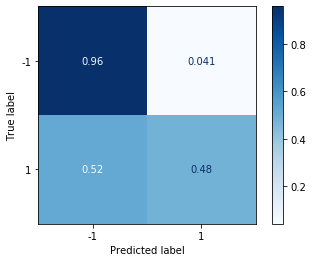

Text(0.5, 1.0, 'Precision-Recall Curve')

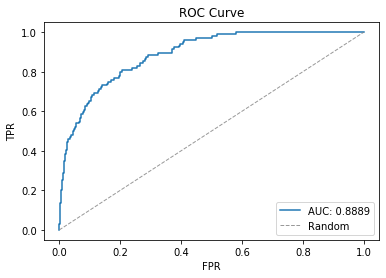

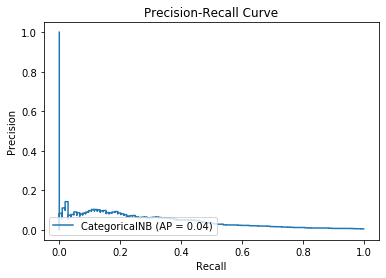

In [12]:
#%%
plot_confusion_matrix(nb, x,y, cmap=plt.cm.Blues, normalize='true')
plt.show()
#fig =plot_roc_curve(nb, x,y, response_method='predict_proba')

y_prop = nb.predict_proba(x)
y_prop =y_prop[:,1]
roc =roc_curve(y_test, y_prop)

label = 'AUC: {:.4}'.format(auc(roc[0], roc[1]))
plt.plot(roc[0], roc[1], label = label)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',label='Random', alpha=.8)
plt.legend()
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

#PR curve
prc = plot_precision_recall_curve(nb, x, y)
prc.ax_.set_title('Precision-Recall Curve')

### Predict hidden data

In [13]:
df_test_hidden = pd.read_csv('exercise_data/human_dna_test_split.csv', header=0, names =['seq', 'label'])
x_test_hidden = df_test_hidden.seq

x, _ = prep_nb(x_test_hidden, y_test)
pred_hidden = nb.predict(x)

np.save('results.npy', pred_hidden)

In [14]:
pd.Series(pred_hidden).value_counts()

-1    31906
 1     1427
dtype: int64

In [15]:
pred_hidden.shape

(33333,)